In [10]:
import os
import PIL
import shutil

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

In [11]:
# Routes
test_dir = '../data/raw/test'
raw_train_dir = '../data/raw/train'
processed_train_dir = '../data/processed/train'

<h4>Cargar imágenes</h4>

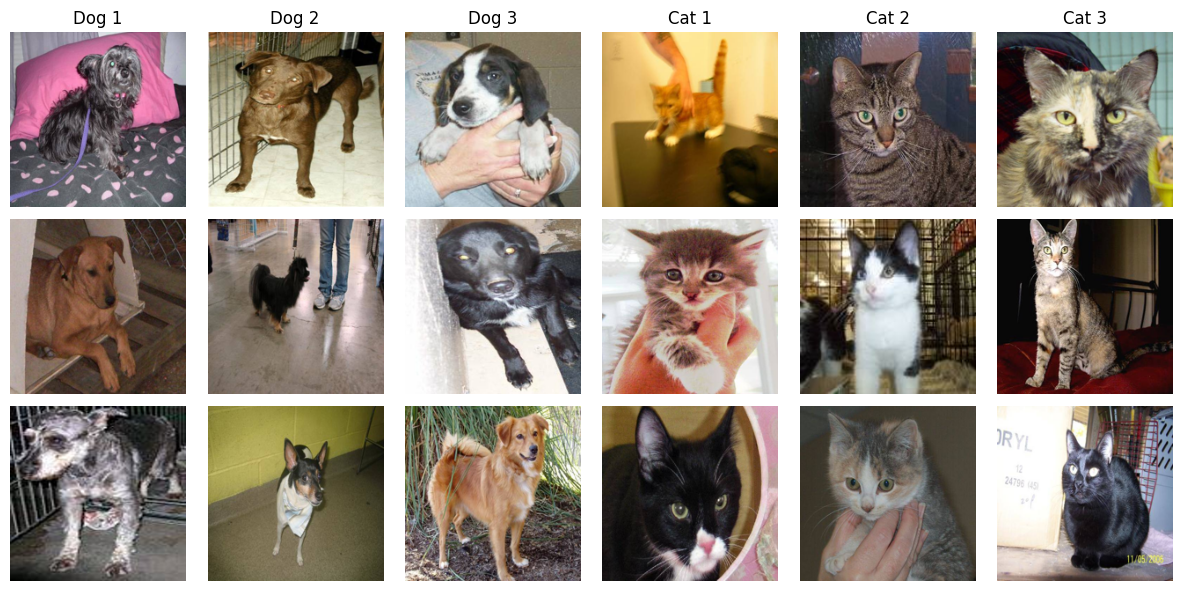

In [12]:
def load_images_by_prefix(prefix, directory, n=9):
    images = []
    count = 0

    try:
        for filename in os.listdir(directory):
            if filename.startswith(prefix) and count < n:
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    try:
                        img_path = os.path.join(directory, filename)
                        img = Image.open(img_path)
                        img = img.resize((200, 200))
                        img_array = np.array(img)
                        images.append(img_array)
                        count += 1
                    except Exception as e:
                            print(f"Error cargando imagen {filename}: {e}")
    except Exception as e:
        print(f"Error de lectura del directorio {directory}: {e}")
    return images

dog_images = load_images_by_prefix('dog', raw_train_dir)
cat_images = load_images_by_prefix('cat', raw_train_dir)

fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(dog_images[i * 3 + j].astype('uint8'))
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'Dog {i * 3 + j + 1}')

for i in range(3):
    for j in range(3):
        axes[i, j + 3].imshow(cat_images[i * 3 + j].astype('uint8'))
        axes[i, j + 3].axis('off')
        if i == 0:
            axes[i, j + 3].set_title(f'Cat {i * 3 + j + 1}')

plt.tight_layout()
plt.show()


<h4>Generar carpetas y clasificar imágenes de train</h4>

In [13]:
os.makedirs(os.path.join(processed_train_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(processed_train_dir, 'cats'), exist_ok=True)

try:
    for filename in os.listdir(raw_train_dir):
        src_path = os.path.join(raw_train_dir, filename)
        
        if filename.startswith('dog'):
            dst_path = os.path.join(processed_train_dir, 'dogs', filename)
        elif filename.startswith('cat'):
            dst_path = os.path.join(processed_train_dir, 'cats', filename)
        else:
            continue

        shutil.move(src_path, dst_path)

except FileNotFoundError as e:
    print(f"Error: Archivo o directorio no encontrado. {e}")
except PermissionError as e:
    print(f"Error: Permiso denegado. {e}")
except shutil.Error as e:
    print(f"Error al mover archivos: {e}")
except Exception as e:
    print(f"Se produjo un error inesperado: {e}")

<h4>Redimensionar imágenes y convertirlas a arrays</h4>

In [14]:
photos = []
labels = []

for category in ['dogs', 'cats']:
    category_dir = os.path.join(processed_train_dir, category)
    
    if not os.path.exists(category_dir):
        print(f"Error: El directorio {category_dir} no existe.")
        continue
    
    for filename in os.listdir(category_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(category_dir, filename)
                
                img = Image.open(img_path)
                img = img.resize((200, 200))
                img_array = img_to_array(img)

                label = 1 if category == 'dogs' else 0

                photos.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error al procesar la imagen {filename}: {e}")

photos = np.array(photos)
labels = np.array(labels)

print(f"Total de fotos: {photos.shape[0]}")
print(f"Tamaño de las fotos: {photos.shape[1:]}")
print(f"Etiquetas: {labels[:10]}")

Total de fotos: 25000
Tamaño de las fotos: (200, 200, 3)
Etiquetas: [1 1 1 1 1 1 1 1 1 1]


<h4>Comprobar etiquetado de imágenes</h4>

In [15]:
print(f"Primera etiqueta: {labels[0]}")
print(f"Última etiqueta: {labels[-1]}")
print(f"Etiquetas únicas: {np.unique(labels)}")

Primera etiqueta: 1
Última etiqueta: 0
Etiquetas únicas: [0 1]


<h4>Crear objeto ImageDataGenerator</h4>

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
trdata = train_datagen.flow_from_directory(
    processed_train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 25000 images belonging to 2 classes.


In [20]:
tsdata = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 12500 images belonging to 1 classes.


In [21]:
print(f"Datos de entrenamiento: {trdata.samples} imágenes")
print(f"Datos de prueba: {tsdata.samples} imágenes")

Datos de entrenamiento: 25000 imágenes
Datos de prueba: 12500 imágenes
